# Position Decomposition

Decomposing a wavefront into Gausslets turns out to be a somewhat involved procedure. 
There are a number of rules to follow:

* The new Gausslets must have direction orthogonal to the wavefront surface (i.e. their direction is the gradient of the phase)
* The Gausslets must have curvature that matches the input wavefront
* The sum of the E-field contributions of the Gausslets should equal the input E-field (ideally, everywhere)

The last of these is a bit of a pain. The Gausslets we create are going to overlap, in order to give a nice
smooth E-field. However, this means they are not independent. The E-field at the origin of one Gausslet 
also include the contribution from the surrounding ones. For a hexagonal-type arrangement, the central mode contributes something like 65% of the amplitude. The immediate neighbours add up to about 30% and the next 
12 further out contribute something like 3% and so on (these are guestimate numbers; hopefully we can 
obtain the concrete values later on in this document). I am expecting that for most applications, the nearest two rings will give sufficient accuracy. 

In [25]:
import sys
sys.path.append("..")
import numpy
from matplotlib import pyplot as pp
from raypier.core.gausslets import calc_mode_curvature, eval_Efield_from_gausslets, \
        build_interaction_matrix, unwrap2d, make_hexagonal_grid
from raypier.core.ctracer import ray_dtype, GaussletCollection, Gausslet, Ray
from raypier.gausslet_sources import GaussianPointSource
from raypier.core.utils import normaliseVector
import k3d

from matplotlib.tri import Triangulation
from scipy.interpolate import RectBivariateSpline

We being by constructing an input mode, being a single Gaussian beam directed along the z-axis and
converging to a beam-waist at (0,0,50).

Let the beam-radius be 10 wavelengths and the wavelength be 1um.

In [2]:
wavelength = 1.0

src = GaussianPointSource(centre=(0,0,0),
                          direction=(0,0,1),
                          E_vector=(1,0,0),
                          E1_amp=1.0,
                          E2_amp=0.0,
                          wavelength=wavelength,
                          resolution=10.0,
                          beam_waist=wavelength*5.0,
                          numerical_aperture=0.1,
                          working_dist=50.0)

input_rays = src.input_rays


In [3]:
o=input_rays.base_rays.origin
r = numpy.sqrt(o[:,0]**2 + o[:,1]**2)
r.max()

5.025189076296061

We can see that our Gaussian beam is roughly 5mm radius at the origin.

We are going to decomposte the wavefront at the origin into modes with a resolution of 20.0 and a maximum
radius of 5mm. This means we'll end up with a gausslet spacing of 0.25mm.

In [4]:
radius = 5.0
resolution = 20.0

We now need to define the origin, orientation and direction of the decomposition plane.

In [5]:
origin = (0,0,0)
direction=(0,0,1)
axis1 = (1,0,0)

Now we being the decomposition routine as given in the `raypier.core.gausslets` module.

In [40]:
spacing = radius / resolution
wavelengths = input_rays.wavelengths

if len(numpy.unique(wavelengths)) > 1:
    raise ValueError("Can't decompose wavefront with more than one wavelength present.")

wavelength = wavelengths[0]

origin = numpy.asarray(origin)
direction = normaliseVector(numpy.asarray(direction))
axis1 = normaliseVector(numpy.asarray(axis1))
axis2 = numpy.cross(axis1, direction)
axis1 = numpy.cross(axis2, direction)

###In this version, we will evaluate the field on a cartesian grid
_radius = radius * (1 + 2./resolution)
x_ = y_ = numpy.linspace(-_radius,_radius, int((1.2*resolution)*2))

x,y = numpy.meshgrid(x_, y_)

origins = origin[None,:] + x.reshape(-1,)[:,None]*axis1[None,:] + y.reshape(-1)[:,None]*axis2[None,:]

E_field = eval_Efield_from_gausslets(input_rays, origins, wavelengths)

In [41]:
intensity = (E_field.real**2 + E_field.imag**2).sum(axis=-1).reshape(*x.shape)

<IPython.core.display.Javascript object>


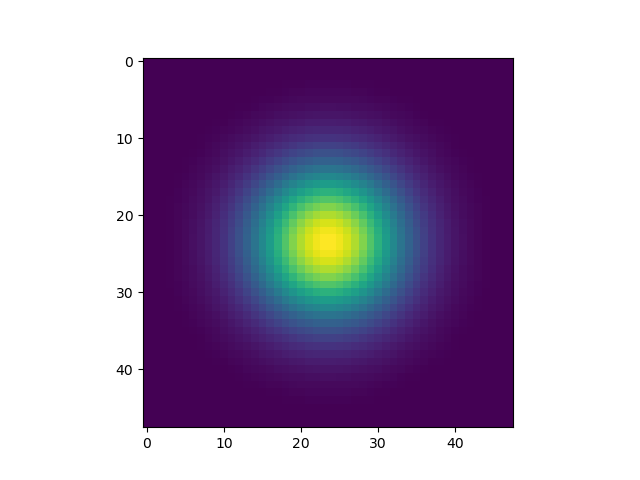

In [42]:
%matplotlib notebook

pp.imshow(intensity)

So far, so good.

Let's define the curvature parameter to be the approx. distance along the decomposition plane direction vector to the focal plane. This will be used to help unwrap the phase.

In [43]:
curvature = 50.0

In [44]:
### Project onto local axes to get orthogonal polarisations and choose the one with the most power
E1_amp = (E_field*axis1[None,:]).sum(axis=1)
E2_amp = (E_field*axis2[None,:]).sum(axis=1)

P1 = (E1_amp.real**2 + E1_amp.imag**2).sum()
P2 = (E2_amp.real**2 + E2_amp.imag**2).sum()

if P1 > P2:
    ### Always in the range -pi to +pi
    phase = numpy.arctan2(E1_amp.imag, E1_amp.real)
else:
    phase = numpy.arctan2(E2_amp.imag, E2_amp.real)

nx = len(x_)
ny = len(y_)
phase.shape = (nx, ny)

if curvature is not None:
    sphz = -(curvature - numpy.sqrt(curvature*curvature - x*x - y*y))
    sph = sphz*2000.0*numpy.pi/wavelength - numpy.pi
    phase = phase - sph
    phase = phase%(2*numpy.pi)
    phase = phase - numpy.pi
else:
    sph = 0

uphase, residuals = unwrap2d(phase, anchor=(nx//2, ny//2))
uphase += sph

In [62]:
x_.shape, y_.shape, uphase.shape

((48,), (48,), (48, 48))

In [45]:
plot = k3d.plot()

surf = k3d.surface(uphase*wavelength/(2000.0*numpy.pi), xmin=x.min(), xmax=x.max(), ymin=y.min(), ymax=y.max())
plot += surf

plot.display()

Output()

In [82]:
### Setting s=0 results in oscillatory behaviour near the edge along the x-idrection.

wavefront = RectBivariateSpline(x_, y_, uphase*wavelength/(2000*numpy.pi), kx=3, ky=3, s=0.001)

### Now make a hex-grid of new ray start-points
rx,ry, nb = make_hexagonal_grid(radius, spacing=spacing, connectivity=True)

N = len(rx)

origins = origin[None,:] + rx[:,None]*axis1[None,:] + ry[:,None]*axis2[None,:]

### First derivatives give us the ray directions
dx = wavefront(rx,ry,dx=1, grid=False)
dy = wavefront(rx,ry,dy=1, grid=False)

### Get second derivatives, to get wavefront curvature
dx2 = wavefront(rx,ry,dx=2, grid=False)
dy2 = wavefront(rx,ry,dy=2, grid=False)
dxdy = wavefront(rx,ry,dx=1,dy=1, grid=False)

### for direction, d:
### d^z gives a unit vector in the xy plane, called D
### D^d gives an orthogonal vector, called G
### A point r on surface is represented as (r.D, r.G)
### x' = (r-o).G, y' = (r-o).D, z' = (r-o).d
### dz'/dx' = 0 by definition

In [73]:
plot = k3d.plot()

indices = Triangulation(rx,ry).triangles.astype(numpy.uint32)

plt_mesh = k3d.mesh(numpy.vstack([rx,ry,dy2*10]).T, indices,
                   color_map = k3d.colormaps.basic_color_maps.Jet,
                   attribute=dy2*20,
                   color_range = [-1.1,2.01]
                   )
plot += plt_mesh
plot.display()

Output()

In [74]:
###Convert to A,B,C coefficients
A,B,C,x,y,z = calc_mode_curvature(rx, ry, dx, dy, dx2, dy2, dxdy)

In [75]:
A.max(), A.min(), B.max(), B.min(), C.max(), C.min()

(0.0001975061328566349,
 1.2961188635270645e-17,
 5.724944762291986e-07,
 -5.754135338400754e-07,
 0.0001965904259732587,
 1.2966982153650825e-17)

In [81]:
z[:,0].max(), z[:,0].min()

(0.09645590758041721, -0.09645586843230955)

In [77]:
x_.min(), x_.max()

(-5.5, 5.5)

Given that the curvature of the surface is somewhat gentle (at least visually), the z-vectors should all be close to unity (the z-component should be about 0.9 near the edge of the sampled range). 

In [78]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr

In [79]:
blending = 1.0
max_spacing = spacing *2
data, (xi, xj) = build_interaction_matrix(rx, ry, A, B,  C, 
                                          x, y, z,
                                          wavelength, spacing, 
                                          max_spacing, blending)

M = coo_matrix( (data,(xi,xj)), shape=(N,N)) #I think M should be Hermitian

E_in = eval_Efield_from_gausslets(input_rays, origins, wavelengths) #should be a (N,3) array of complex values

E_out_x = lsqr(M, E_in[:,0])[0]
E_out_y = lsqr(M, E_in[:,1])[0]
E_out_z = lsqr(M, E_in[:,2])[0]

ray_data = numpy.zeros(N, dtype=ray_dtype)

### Now need to construct the GaussletCollection.

The exact solution is  x = 0                              


In [80]:
E_out_x

array([-0.02973507-1.29103414j, -0.3745251 +0.94531883j,
       -0.37462409+0.94539014j, ..., -0.3745251 +0.94531883j,
       -0.37462409+0.94539014j, -0.0295217 -1.29126628j])

In [19]:
M.shape[0]*M.shape[1]

2111209

In [20]:
dx2.max(), dy2.max()

(0.008627886530519486, -0.019649590810385635)